<a href="https://colab.research.google.com/github/BestUazDriver/TSISA/blob/main/8_%D0%A1%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическое занятие №8.1. Экспертные системы.

Создайте экспертную систему для постановки диагноза и рекомендации лечения.

1. Выберите не менее двух диагнозов. При выборе диагнозов нужно использовать:

- а) лекцию по спреям;
- б) Анемии 2.pptx;
- в) med.xlsx.

Диагнозы, которые никак не касаются содержимого этих документов, выбиратбь нельзя!

2. В интерфейсе пользователя предусмотрите возможность ввода результатов лабораторных исследований, осмотра врача, жалоб пациентов.
3. В базе знаний анализируйте значения следующих переменных:
- $А_1=(А_{11}, А_{12}, …, A_{1k}\})=\{\text {результаты лабораторных исследований}\}$;
- $А_2=(А_{21}, А_{22}, …, A_{2m})=\{\text {результаты объективного осмотра}\}$;
- $А_3=(А_{31}, А_{32}, …, A_{3n})=\{\text {жалобы пациента}\}$;
- $А_4=(А_{41}, А_{42}, …, A_{4N})=\{\text {диагнозы}\}$;
- $А_5=(А_{51}, А_{52}, …, A_{5M})=\{\text {лечение}\}$.

Для создания правил расставьте приоритеты обращения к переменным. При необходимости добавьте другие типы переменных. Использование всех вышеперечисленных переменных не обязательно.

4. К каждому созданному правилу приложите компоненту объяснения на естественном языке.
5. В механизме логического вывода используйте структуру бинарного дерева.
6. Результатом работы системы могут являться диагноз и рекомендации к лечению.
7. Создайте модуль для кластеризации данных, используя карту Кохонена, выбрав три медицинских показателя из файла med.xlsx. Проведите анализ полученной цветовой гаммы.





In [ ]:
from collections import Counter
from random import uniform

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import clear_output

import warnings

warnings.filterwarnings("ignore")

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
# Display up to 300 columns of a dataframe
pd.set_option("display.max_columns", 300)

plt.rcParams["font.size"] = 24
sns.set(style="darkgrid", font_scale=2)
sns.set_style({"font.family": "serif"})


In [ ]:
file_path = "med.xlsx"
data = pd.read_excel(file_path)

In [ ]:
def display_dataframe(df: pd.DataFrame) -> None:
    display(df.shape, pd.concat((pd.concat((df.head(2), df.sample(3))), df.tail(2))))

In [ ]:
display_dataframe(data)

(115262, 28)

,Nr.,Reference Date,Principal Practitioner Name CVRM,Organisation Name (CVRM Treatment),Organisation Name (CVRM Treatment).1,Treatment Startdate CVRM,Risk Score CVRM,MDRD,"MDRD, last measurement date",Glucose Fasting,"Glucose Fasting, last measurement date",Total Cholesterol,"Total Cholesterol, last measurement date",Systolic Blood Pressure,Diastolic Blood Pressure,"Systolic Blood Pressure, last measurement date",BMI,"BMI, last measurement date",Primary / Secondary CVRM,Smoking Status,Date Last Contact CVRM,Patient Gender,Age,Hypertension,"Annual Checkup CVRM (Dutch version), Date Last","Annual Checkup CVRM (Russian version), Date Last",Date Last Interim Checkup CVRM (Dutch version),Date Last Interim Checkup CVRM (Russian version)
0,1,2020-12-31,"Сулейманова, Фирюза Харисовна",ГП №9 при ГБ5 г.Наб. Челны,1,2018-11-19,NaN,NaN,NaT,NaN,NaT,5.0,2019-07-04,130.0,80.0,2018-11-19,25.0,2018-11-19,Primary,Never,2018-11-19,M,62,Yes,NaT,1920-10-25,2018-11-19,NaT
1,2,2020-12-31,"Васильевская УБ - Габитова, Ильмира Шавкатовна",ПО Прочие Зеленод. ЦРБ,1,2019-11-03,4.0,65.0,2019-10-21,5.0,2019-10-21,5.8,2019-10-21,130.0,90.0,2010-10-25,28.0,2010-10-25,Primary,Never,2010-10-25,F,76,Yes,NaT,2010-10-25,NaT,NaT
15618,15619,2020-12-31,"ТО3 - Фатхутдинов, Ильфат Маратович",ГП №18 г. Казани,1,2019-08-27,5.0,NaN,NaT,6.1,2019-08-09,7.0,2019-08-09,136.0,68.0,2019-08-27,NaN,NaT,Primary,Never,2019-08-27,F,79,NaN,NaT,2019-08-27,NaT,NaT
384,385,2020-12-31,"Жданова, Екатерина Ильинична",ГКБ №18 г.Казань,1,2018-12-19,NaN,NaN,NaT,5.1,2018-12-18,6.4,2018-12-18,140.0,80.0,2019-12-14,28.0,2018-12-19,Primary,NaN,2019-12-14,F,80,NaN,NaT,2018-12-19,NaT,2019-12-14
52984,52985,2020-12-31,"ПО1 - Петрашова, Надежда Александровна",НЦРМБ г.Нижнекамск,1,2019-12-15,NaN,56.0,2019-11-29,6.1,2019-11-29,4.0,2019-11-29,150.0,80.0,2019-12-06,37.0,2019-12-06,Secondary,Never,2019-12-06,F,73,Yes,NaT,2019-12-06,NaT,NaT
115260,115261,2020-12-31,"Кокорин, Михаил Иванович",ГП №5 при ГБ5 г.Наб. Челны,1,2018-11-26,5.0,NaN,NaT,5.7,2019-03-25,5.1,2019-03-25,135.0,80.0,2019-09-13,27.0,2019-09-13,Primary,Never,2019-09-13,M,62,Yes,2018-11-26,NaT,NaT,2019-09-13
115261,115262,2020-12-31,"Абзалутдинова, Сания Изаховна",ГП №21 г.Казань,1,2018-11-26,NaN,NaN,NaT,NaN,NaT,NaN,NaT,160.0,100.0,2020-02-20,31.0,2020-02-20,Primary,Never,2020-02-20,F,79,Yes,2018-11-26,NaT,NaT,2020-02-20


Набор данных включает в себя различные медицинские показатели, такие как возраст, пол, наличие гипертонии, результаты различных исследований и т.д.

Из столбцов можно выделить категории данных, которые можно использовать в экспертной системе:

- **Лабораторные исследования (A1):**
    - `Glucose Fasting (Уровень глюкозы натощак)`
    - `Total Cholesterol (Общий холестерин)`
    - `MDRD (Фильтрационная способность почек)`
- **Результаты объективного осмотра (A2):**
    - `Systolic Blood Pressure (Систолическое артериальное давление)`
    - `Diastolic Blood Pressure (Диастолическое артериальное давление)`
    - `BMI (Индекс массы тела)`
- **Жалобы пациента (A3):**
    - В данном наборе данных прямых указаний на жалобы пациента нет, но можно использовать косвенные показатели, такие как `Smoking Status (Статус курения)` и `Age (Возраст)`, по которым можно определить потенциальные заболевания.

# Предобработка данных

In [ ]:
# Удаляем столбцы, которые не будут использоваться в моделях
columns_to_use = [
    "Glucose Fasting",
    "Total Cholesterol",
    "MDRD",
    "Systolic Blood Pressure",
    "Diastolic Blood Pressure",
    "BMI",
    "Age",
    "Patient Gender",
]
data_ml = data[columns_to_use]


Обработка пропущенных значений: замена их средними значениями


In [ ]:
data_ml.fillna(data_ml.mean(), inplace=True)


**Кодирование категориальных переменных**

In [ ]:
data_ml = pd.get_dummies(data_ml, columns=["Patient Gender"], drop_first=True)


**Создание целевых переменных**



1. `Hypertension`: Гипертония
    - 1 - если высокое давление
        - систолическое АД > 140 или диастолическое АД > 90.
    - 0 - в противном случае.
2. `Diabetes`: Сахарный диабет
    - 1 - если высокий уровень глюкозы;
        - уровень глюкозы натощак > 7.0 ммоль/л
    - 0 - в противном случае.

In [ ]:
# Гипертония
data_ml["Hypertension"] = (
    (data_ml["Systolic Blood Pressure"] > 140)
    | (data_ml["Diastolic Blood Pressure"] > 90)
).astype(int)


# Сахарный диабет
data_ml["Diabetes"] = (data_ml["Glucose Fasting"] > 7.0).astype(int)

In [ ]:
# Проверка результатов предобработки
display_dataframe(data_ml)

(115262, 10)

,Glucose Fasting,Total Cholesterol,MDRD,Systolic Blood Pressure,Diastolic Blood Pressure,BMI,Age,Patient Gender_M,Hypertension,Diabetes
0,5.322688,5.000000,80.209738,130.0,80.0,25.0,62,1,0,0
1,5.000000,5.800000,65.000000,130.0,90.0,28.0,76,0,0,0
10396,4.700000,4.300000,90.000000,130.0,90.0,29.0,78,1,0,0
113333,4.500000,6.100000,80.209738,160.0,100.0,27.0,72,0,1,0
2434,8.000000,7.200000,58.000000,130.0,80.0,28.0,64,0,0,1
115260,5.700000,5.100000,80.209738,135.0,80.0,27.0,62,1,0,0
115261,5.322688,5.506643,80.209738,160.0,100.0,31.0,79,0,1,0


Нормализация признаков

In [ ]:
feature_columns = list(data_ml.drop(columns=["Hypertension", "Diabetes"]).columns)

In [ ]:
feature_columns

['Glucose Fasting',
 'Total Cholesterol',
 'MDRD',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'BMI',
 'Age',
 'Patient Gender_M']

In [ ]:
ct = ColumnTransformer(
    [("StandardScaler", StandardScaler(), feature_columns)],
    remainder="passthrough",
)

data_ml[feature_columns] = ct.fit_transform(data_ml[feature_columns])


**Разделение данных на обучающую и тестовую выборки**

In [ ]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Определение признаков и целевых переменных
X_hypertension = data_ml.drop(
    columns=[
        "Hypertension",
        "Diabetes",
        "Systolic Blood Pressure",
        "Diastolic Blood Pressure",
    ]
)
y_hypertension = data_ml["Hypertension"]

X_diabetes = data_ml.drop(columns=["Hypertension", "Diabetes", "Glucose Fasting"])
y_diabetes = data_ml["Diabetes"]


In [ ]:
# Разделение данных на обучающую и тестовую выборки для каждого диагноза
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_hypertension, y_hypertension, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_diabetes, y_diabetes, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


In [ ]:
print("Признаки для гипертензии", list(X_train_h.columns))
print("Признаки для диабета", list(X_train_d.columns))

Признаки для гипертензии ['Glucose Fasting', 'Total Cholesterol', 'MDRD', 'BMI', 'Age', 'Patient Gender_M']
Признаки для диабета ['Total Cholesterol', 'MDRD', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'BMI', 'Age', 'Patient Gender_M']


Обучим модели KNeighborsClassifier и DecisionTreeClassifier. Эти модели будут предсказывать вероятности наличия гипертонии и сахарного диабета на основе введенных пользователем данных

# Обучение моделей для гипертонии

GridSearchCV для настройки гиперпараметров

In [ ]:
# Начнем с KNeighborsClassifier
params_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 13],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}
clf_knn_h = GridSearchCV(KNeighborsClassifier(), params_knn)
clf_knn_h.fit(X_train_h, y_train_h)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']})

In [ ]:
print(
    "Лучшие параметры для KNeighborsClassifier (гипертония):",
    clf_knn_h.best_params_
)
print(
    "Точность KNeighborsClassifier (гипертония):",
    accuracy_score(y_test_h, clf_knn_h.predict(X_test_h)),
)

Лучшие параметры для KNeighborsClassifier (гипертония): {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
Точность KNeighborsClassifier (гипертония): 0.7020405330372016


In [ ]:
# Затем DecisionTreeClassifier
params_dtc = {
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
}
clf_dtc_h = GridSearchCV(DecisionTreeClassifier(), params_dtc)
clf_dtc_h.fit(X_train_h, y_train_h)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [ ]:
print(
    "Лучшие параметры для DecisionTreeClassifier (гипертония):",
    clf_dtc_h.best_params_
)
print(
    "Точность DecisionTreeClassifier (гипертония):",
    accuracy_score(y_test_h, clf_dtc_h.predict(X_test_h)),
)


Лучшие параметры для DecisionTreeClassifier (гипертония): {'criterion': 'gini', 'max_depth': 4}
Точность DecisionTreeClassifier (гипертония): 0.7198431426985008


In [ ]:
best_hypertension_clf = clf_dtc_h

# Обучение моделей для сахарного диабета


In [ ]:
# Начнем с KNeighborsClassifier
params_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 13],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}
clf_knn_d = GridSearchCV(KNeighborsClassifier(), params_knn)
clf_knn_d.fit(X_train_d, y_train_d)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']})

In [ ]:
print(
    "Лучшие параметры для KNeighborsClassifier (гипертония):",
    clf_knn_d.best_params_
)
print(
    "Точность KNeighborsClassifier (гипертония):",
    accuracy_score(y_test_d, clf_knn_d.predict(X_test_d)),
)

Лучшие параметры для KNeighborsClassifier (гипертония): {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
Точность KNeighborsClassifier (гипертония): 0.9551985008328706


In [ ]:
# Затем DecisionTreeClassifier
params_dtc = {
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
}
clf_dtc_d = GridSearchCV(DecisionTreeClassifier(), params_dtc)
clf_dtc_d.fit(X_train_d, y_train_d)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [ ]:
print(
    "Лучшие параметры для DecisionTreeClassifier (гипертония):",
    clf_dtc_d.best_params_
)
print(
    "Точность DecisionTreeClassifier (гипертония):",
    accuracy_score(y_test_d, clf_dtc_d.predict(X_test_d)),
)


Лучшие параметры для DecisionTreeClassifier (гипертония): {'criterion': 'entropy', 'max_depth': 4}
Точность DecisionTreeClassifier (гипертония): 0.9552332037756802


In [ ]:
best_diabetes_clf = clf_dtc_d

# Интерфейс для пользователя

Интерфейс для пользователя с возможностью ввода результатов лабораторных исследований, осмотра врача, жалоб пациентов.

In [ ]:
def predict_diseases(patient_data, best_hypertension_clf, best_diabetes_clf, ct):
    """
    Принимает данные пациента и две обученные модели для предсказания гипертензии и диабета.
    Возвращает предсказания для каждого заболевания.
    """

    # Преобразование данных пола пациента
    patient_data["Patient Gender_M"] = 1 if patient_data["Patient Gender"] == "M" else 0
    del patient_data["Patient Gender"]

    # Преобразование словаря в DataFrame
    patient_df = pd.DataFrame([patient_data])

    # Стандартизация данных
    patient_df = pd.DataFrame(ct.transform(patient_df), columns=patient_df.columns)

    # Подготовка данных для моделей
    data_for_hypertension = patient_df[
        [
            "Glucose Fasting",
            "Total Cholesterol",
            "MDRD",
            "BMI",
            "Age",
            "Patient Gender_M",
        ]
    ]
    data_for_diabetes = patient_df[
        [
            "Total Cholesterol",
            "MDRD",
            "Systolic Blood Pressure",
            "Diastolic Blood Pressure",
            "BMI",
            "Age",
            "Patient Gender_M",
        ]
    ]

    # Предсказание заболеваний
    hypertension_prediction = best_hypertension_clf.predict(data_for_hypertension)[0]
    diabetes_prediction = best_diabetes_clf.predict(data_for_diabetes)[0]

    return hypertension_prediction, diabetes_prediction


In [ ]:
def collect_patient_data():
    """
    Функция для сбора медицинских данных пациента.
    """
    print("Введите медицинские данные пациента.")

    # Лабораторные исследования
    glucose_fasting = float(input("Уровень глюкозы натощак (ммоль/л): "))
    total_cholesterol = float(input("Общий холестерин (ммоль/л): "))
    mdrd = float(input("Фильтрационная способность почек (MDRD, мл/мин/1.73м²): "))

    # Результаты объективного осмотра
    systolic_bp = float(input("Систолическое артериальное давление (мм рт. ст.): "))
    diastolic_bp = float(input("Диастолическое артериальное давление (мм рт. ст.): "))
    bmi = float(input("Индекс массы тела (BMI): "))

    # Дополнительные данные
    gender = input("Пол пациента (M/F): ")
    age = int(input("Возраст пациента: "))

    patient_data = {
        "Glucose Fasting": glucose_fasting,
        "Total Cholesterol": total_cholesterol,
        "MDRD": mdrd,
        "Systolic Blood Pressure": systolic_bp,
        "Diastolic Blood Pressure": diastolic_bp,
        "BMI": bmi,
        "Patient Gender": gender,
        "Age": age
    }

    return patient_data


In [ ]:
# patient_data = collect_patient_data()
patient_data = {
    "Glucose Fasting": 1000,
    "Total Cholesterol": 1000,
    "MDRD": 1000,
    "Systolic Blood Pressure": 1000,
    "Diastolic Blood Pressure": 1000,
    "BMI": 1000,
    "Patient Gender": "1",
    "Age": 1000,
}


In [ ]:
hypertension_pred, diabetes_pred = predict_diseases(
    patient_data, best_hypertension_clf, best_diabetes_clf, ct
)
print("Риск гипертензии:", hypertension_pred)
print("Риск диабета:", diabetes_pred)


Риск гипертензии: 1
Риск диабета: 0


# Кластеризация с помощью карты Кохонена

Обучим карту Кохонена на данных и проанализируем результаты.

Выберем три медицинских показателя из файла. Возьмем, к примеру, следующие показатели:

- `Уровень глюкозы натощак (Glucose Fasting)`
- `Общий холестерин (Total Cholesterol)`
- `Систолическое артериальное давление (Systolic Blood Pressure)`


In [ ]:
selected_features = ['Glucose Fasting', 'Total Cholesterol', 'Systolic Blood Pressure']
data_selected = data_ml[selected_features].dropna()

In [ ]:
# Стандартизация данных
data_std = (data_selected - data_selected.mean()) / data_selected.std()
data_np = data_std.values

data_np.shape, data_std.head()

((115262, 3),
    Glucose Fasting  Total Cholesterol  Systolic Blood Pressure
 0     6.380321e-17          -0.244699                -0.538924
 1    -1.920009e-01           0.141686                -0.538924
 2    -1.325004e-01           0.045090                 0.970753
 3     1.355014e+00           0.286580                 0.970753
 4    -7.299977e-02           0.576369                -2.048601)

## Обучение карты Кохонена

In [ ]:
!pip install -q MiniSom

  Preparing metadata (setup.py) ... done


In [ ]:
from minisom import MiniSom

В коде ниже:
- `x=10, y=10` задает размеры карты.
- `input_len=len(selected_features)` указывает на количество входных признаков.
- `sigma` и `learning_rate` - параметры обучения.

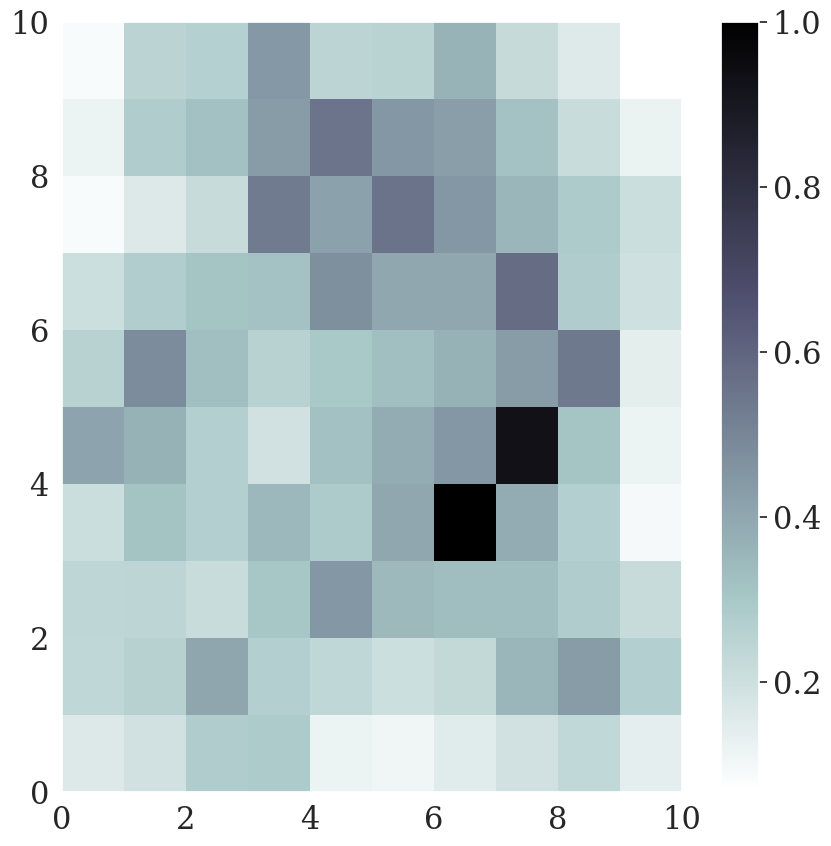

In [ ]:
# Инициализация карты Кохонена
som = MiniSom(
    x=10, y=10, input_len=len(selected_features), sigma=0.5, learning_rate=0.5
)

# Случайная инициализация весов
som.random_weights_init(data_np)

# Обучение
som.train_random(data_np, 100)

# Визуализация карты
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap="bone_r")  # Визуализация карты расстояний
plt.colorbar()
plt.show()


**Интерпретация карты:**

- **Темные ячейки:** Большое расстояние. Векторы признаков сильно отличаются друг от друга. Такие области обычно представляют границы между различными кластерами на карте.
- **Светлые ячейки:** Приближенные к белому цвету, показывают меньшие расстояния. Это указывает на то, что векторы признаков более похожи друг на друга. Это говорит о принадлежности к одному кластеру или близким кластерам.
- **Градиент цветов:** Плавный переход от темных к светлым оттенкам указывает на наличие связанных или переходных кластеров.

**Распределение признаков по карте**

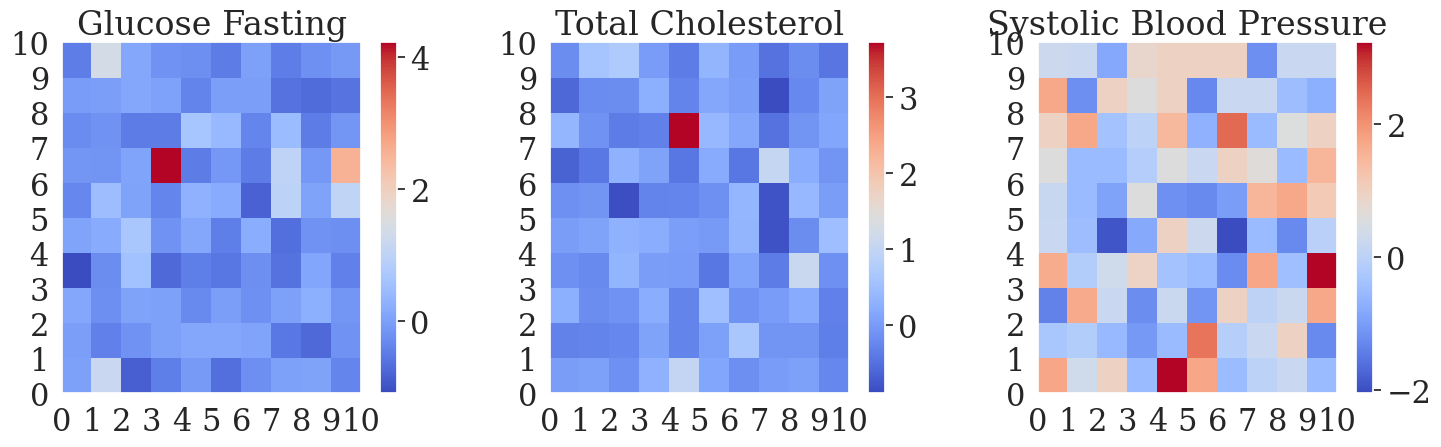

In [ ]:
def plot_component_planes(som, feature_names):
    n_features = len(feature_names)
    plt.figure(figsize=(n_features * 5, 5))
    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, n_features, i + 1)
        plt.title(feature_name)
        component_plane = som.get_weights()[:, :, i]
        plt.pcolor(component_plane, cmap="coolwarm")
        plt.colorbar()
        plt.xticks(np.arange(component_plane.shape[0] + 1))
        plt.yticks(np.arange(component_plane.shape[1] + 1))
    plt.tight_layout()
    plt.show()


plot_component_planes(som, selected_features)
